0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40



41



42



43



44



45



46



47



48



49



50



51



52



53



54



55



56



57



58



59



60



61



62



63



64



65



66



67



68



69



70



71



72



73



74



75



76



77



78



79



80



81



82



83



84



85



86



87



88



89



90



91



92



93



94



95



96



97



98



99


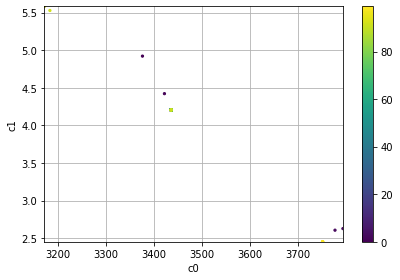

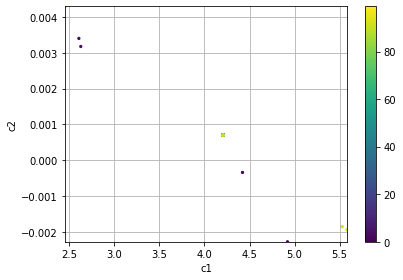

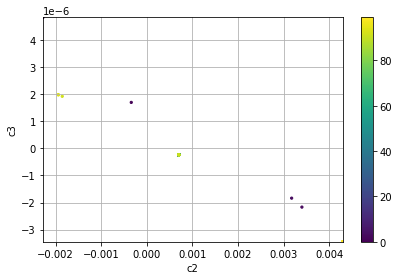

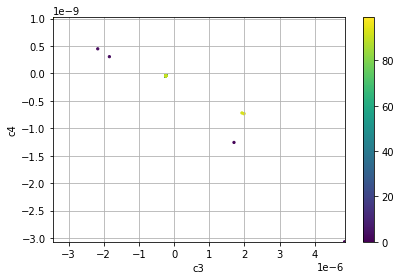

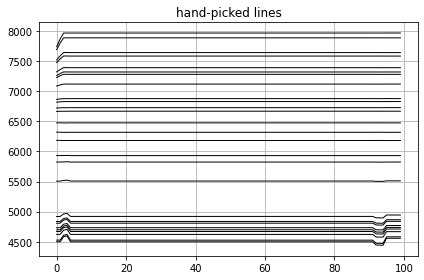

In [2]:
import os
import logging

from astropy.io import fits
from matplotlib import pyplot as plt

import numpy as np
import pytest
from scipy.signal import find_peaks
from tqdm.autonotebook import tqdm

from rascal.calibrator import Calibrator
from rascal import models
from rascal import util


# Load the LT SPRAT data
spectrum2D = fits.open('data_lt_sprat/v_a_20190516_57_1_0_1.fits')[0].data
# Collapse into 1D spectrum between row 110 and 120
spectrum = np.median(spectrum2D[110:120], axis=0)
# Identify the peaks
peaks, _ = find_peaks(spectrum, height=1000, distance=5, threshold=None)
peaks = util.refine_peaks(spectrum, peaks, window_width=5)

# Initialise the calibrator
c = Calibrator(peaks, num_pix=1024, min_wavelength=3500., max_wavelength=8000.)
c.set_fit_constraints(num_slopes=5000,
                      range_tolerance=500.,
                      xbins=100,
                      ybins=100)
# blend: 4829.71, 4844.33
# blend: 5566.62, 5581.88
# blend: 6261.212, 6265.302
# blend: 6872.11, 6882.16
# blend: 7283.961, 7285.301
# blend: 7316.272, 7321.452
atlas = [4193.5, 4385.77,
    4500.98, 4524.68, 4582.75, 4624.28, 4671.23, 4697.02, 4734.15, 4807.02, 4921.48,
    5028.28,
    5618.88, 5823.89, 5893.29, 5934.17,
    6182.42, 6318.06, 6472.841,
    6595.56, 6668.92, 6728.01, 6827.32, 6976.18,
    7119.60, 7257.9, 7393.8,
    7584.68, 7642.02, 7740.31, 7802.65, 7887.40, 7967.34, 8057.258]
element = ['Xe'] * len(atlas)

c.load_user_atlas(element, atlas)

c.set_peaks(constrain_poly=True)

def run_sprat_calibration(polydeg, peaks):
    # Run the wavelength calibration
    best_p, rms, residual, peak_utilisation = c.fit(max_tries=10000)
    # First set is to refine only the 0th and 1st coefficient (i.e. the 2 lowest orders)
    best_p, x_fit, y_fit, residual, peak_utilisation = c.match_peaks(
        best_p,
        delta=best_p[:1] * 0.001,
        tolerance=10.,
        convergence=1e-10,
        method='Nelder-Mead',
        robust_refit=True,
        polydeg=polydeg)
    # Second set is to refine all the coefficients
    best_p, x_fit, y_fit, residual, peak_utilisation = c.match_peaks(
        best_p,
        delta=best_p * 0.001,
        tolerance=10.,
        convergence=1e-10,
        method='Nelder-Mead',
        robust_refit=True,
        polydeg=polydeg)
    wave = np.polynomial.polynomial.polyval(peaks, best_p)
    return best_p, residual, peak_utilisation, rms, wave


# run n times
n = 100

c0 = np.zeros(n)
c1 = np.zeros(n)
c2 = np.zeros(n)
c3 = np.zeros(n)
c4 = np.zeros(n)
peak_utilisation = np.zeros(n)
rms = np.zeros(n)
waves = np.zeros((n, len(peaks)))

for i in range(n):
    print(i)
    best_p, _, peak_utilisation[i], rms[i], waves[i] = run_sprat_calibration(4, peaks)
    c0[i], c1[i], c2[i], c3[i], c4[i] = best_p


#sort by the wavelength fitted to the largest pixel value
mask_sorted = np.argsort(waves[:,-1])

plt.figure(1)
plt.clf()
plt.scatter(c0[mask_sorted], c1[mask_sorted], c=np.arange(n), s=5)
plt.xlabel('c0')
plt.ylabel('c1')
plt.xlim(min(c0), max(c0))
plt.ylim(min(c1), max(c1))
plt.colorbar()
plt.grid()
plt.tight_layout()

plt.figure(2)
plt.clf()
plt.scatter(c1[mask_sorted], c2[mask_sorted], c=np.arange(n), s=5)
plt.xlabel('c1')
plt.ylabel('c2')
plt.xlim(min(c1), max(c1))
plt.ylim(min(c2), max(c2))
plt.colorbar()
plt.grid()
plt.tight_layout()

plt.figure(3)
plt.clf()
plt.scatter(c2[mask_sorted], c3[mask_sorted], c=np.arange(n), s=5)
plt.xlabel('c2')
plt.ylabel('c3')
plt.xlim(min(c2), max(c2))
plt.ylim(min(c3), max(c3))
plt.colorbar()
plt.grid()
plt.tight_layout()

plt.figure(4)
plt.clf()
plt.scatter(c3[mask_sorted], c4[mask_sorted], c=np.arange(n), s=5)
plt.xlabel('c3')
plt.ylabel('c4')
plt.xlim(min(c3), max(c3))
plt.ylim(min(c4), max(c4))
plt.colorbar()
plt.grid()
plt.tight_layout()

plt.figure(5)
plt.clf()
for i in range(len(peaks)):
    plt.plot(waves[mask_sorted][:,i], color='black', lw=1)

plt.title('hand-picked lines')
plt.grid()
plt.tight_layout()
